In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import glob
import pandas as pd
from scipy import integrate
from scipy.stats import linregress
from matplotlib import cm
from matplotlib.colors import ListedColormap

In [2]:
#Constants
a=6371220 #radius of earth in m
L=2.5E6 #Latent heat in atmosphere
L_ice=3.34e5 #Latent heat of fusion
g=9.81 #Acceleration from gravity
conv_pw=1e15 #Conversion from watts to PW
cp=1007  



In [3]:
#Make some standardized coordinates

lats = np.arange(-90, 91, 1)
geometry = 2 * np.pi * np.cos(np.deg2rad(np.asarray(lats))) * a / g
levels_pa = np.array([100, 500, 1000, 2000, 3000, 5000, 7000, 10000, 15000, 20000, 25000, 30000, 40000, 50000, 60000,
             70000, 85000, 92500, 100000])
levels_hPa = levels_pa / 100

In [4]:
amip_ds = xr.open_dataset('../amip_aht.nc')
hist_ds = xr.open_dataset('../hist_aht.nc')
reanalysis_ds = xr.open_dataset('../reanalysis_aht.nc')

amip_trends = amip_ds.groupby('time.year').mean('time').polyfit(dim = 'year', deg = 1, cov=True)
hist_trends = hist_ds.groupby('time.year').mean('time').polyfit(dim = 'year', deg = 1, cov=True)
reanalysis_trends = reanalysis_ds.groupby('time.year').mean('time').polyfit(dim = 'year', deg = 1, cov=True)

In [5]:
def trend(x):
    return x.polyfit('time', deg=1)

amip_trends_month = amip_ds.groupby('time.month').apply(trend) * 1e9 * 3600 * 24 * 365 * 40 / 1e15
hist_trends_month = hist_ds.groupby('time.month').apply(trend)  * 1e9 * 3600 * 24 * 365 * 40 / 1e15
reanalysis_trends_month = reanalysis_ds.groupby('time.month').apply(trend)  * 1e9 * 3600 * 24 * 365 * 40 / 1e15

In [21]:
hist_std_error = xr.open_dataset('../hist_ds_trend_std_error.nc')
reanalysis_std_error = xr.open_dataset('../reanalysis_ds_trend_std_error.nc')

hist_Neff = xr.open_dataset('../hist_ds_trend_Neff.nc')
reanalysis_Neff = xr.open_dataset('../reanalysis_ds_trend_Neff.nc')

In [6]:
                 
interactive_models = ['CESM2-WACCM', 'CNRM-ESM2-1', 'GFDL-ESM4', 'MRI-ESM2-0', 'UKESM1-0-LL', 'CNRM-CM6-1',
                      'E3SM-1-0', 'GFDL-ESM4', 'GISS-E2-1-G', 'GISS-E2-2-G', 'GISS-E2-1-H']

lat_slice = slice(-70, -50)
all_models = list(hist_ds.model.values)

non_interactive_models = list(set(all_models) - set(list(interactive_models)))

vals_interactive = []
vals_non_interactive = []

vals = hist_trends_month.se_aht_polyfit_coefficients.sel(month=10).sel(degree=1).sel(latitude=lat_slice).mean('latitude').values
models =  hist_trends_month.model.values

reanalysis_vals = reanalysis_trends_month.se_aht_polyfit_coefficients.sel(month=10).sel(degree=1).sel(latitude=lat_slice).mean(['latitude', 'model']).values

print(f'Reanalysis ave is {np.round(reanalysis_vals, 2)}')

for i in range(len(vals)):
    
    #if models[i] in non_interactive_models:
        #vals_non_interactive.append(vals[i])
    if models[i] not in interactive_models:
        vals_non_interactive.append(vals[i])
    elif models[i] in interactive_models:
        vals_interactive.append(vals[i])
    
    #print(f'{models[i]}: {round(vals[i], 2)}')

print(f' Interactive {round(np.mean(np.array(vals_interactive)), 2)} for {len(vals_interactive)} values')
print(f' Non-interactive {round(np.mean(np.array(vals_non_interactive)), 2)} for {len(vals_non_interactive)} values')


Reanalysis ave is -0.3
 Interactive -0.12 for 4 values
 Non-interactive 0.07 for 27 values


/tdat/tylersc/mini3/envs/jupyter_new/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1389: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,


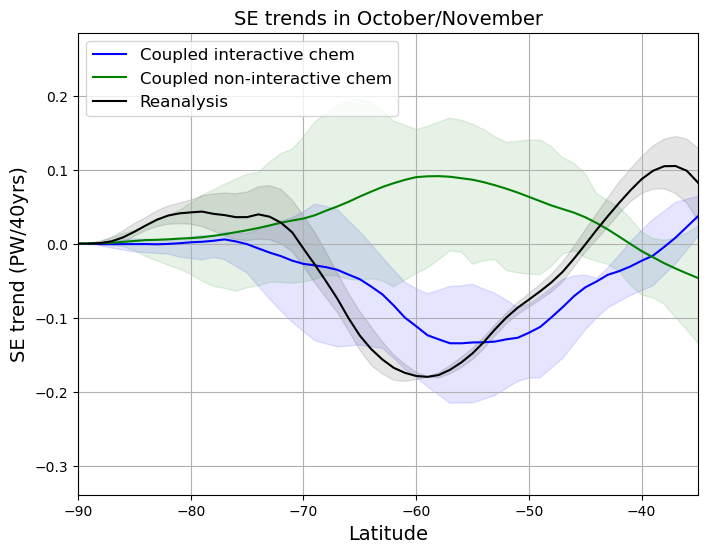

In [55]:
plt.figure(figsize=(8,6))
aht_conv = 40 / 1e15
which_quantiles = [0.25, 0.75]

which_month = [10, 11]
hist_interactive = hist_trends_month.sel(month=which_month).sel(model = hist_trends.model.isin(interactive_models)).sel(degree=1).mean('month')
hist_non_interactive = hist_trends_month.sel(month=which_month).sel(model = hist_trends.model.isin(non_interactive_models)).sel(degree=1).mean('month')
hist_interactive_quantile = hist_trends_month.sel(month=which_month).sel(model = hist_trends.model.isin(interactive_models)).sel(degree=1).mean('month').quantile(which_quantiles, dim='model')
hist_non_interactive_quantile = hist_trends_month.sel(month=which_month).sel(model = hist_trends.model.isin(non_interactive_models)).sel(degree=1).mean('month').quantile(which_quantiles, dim='model')

hist_se_aht_std_err_interactive = aht_conv * np.sqrt((hist_std_error.sel(model = hist_trends.model.isin(interactive_models)).se_aht ** 2 / hist_Neff.se_aht.sel(model = hist_trends.model.isin(interactive_models))).sum('model'))
hist_se_aht_std_err_non_interactive = aht_conv * np.sqrt((hist_std_error.sel(model = hist_trends.model.isin(non_interactive_models)).se_aht ** 2 / hist_Neff.se_aht.sel(model = hist_trends.model.isin(non_interactive_models))).sum('model'))
reanalysis_se_aht_std_err = aht_conv * np.sqrt((reanalysis_std_error.se_aht ** 2 / reanalysis_Neff.se_aht).sum('model'))


plt.plot(hist_interactive.latitude, hist_interactive.se_aht_polyfit_coefficients.mean('model'), color='b', label='Coupled interactive chem')
plt.fill_between(hist_interactive.latitude,  hist_interactive_quantile.se_aht_polyfit_coefficients.isel(quantile=0),
                      hist_interactive_quantile.se_aht_polyfit_coefficients.isel(quantile=1), color='b', alpha=0.1)

#plt.fill_between(hist_interactive.latitude,  hist_interactive.se_aht_polyfit_coefficients - hist_se_aht_std_err_interactive,
                      #hist_interactive.se_aht_polyfit_coefficients + hist_se_aht_std_err_interactive, color='b', alpha=0.1)

plt.plot(hist_non_interactive.latitude, hist_non_interactive.se_aht_polyfit_coefficients.mean('model'), color='g', label='Coupled non-interactive chem')
plt.fill_between(hist_non_interactive.latitude,  hist_non_interactive_quantile.se_aht_polyfit_coefficients.isel(quantile=0),
                      hist_non_interactive_quantile.se_aht_polyfit_coefficients.isel(quantile=1), color='g', alpha=0.1)

#plt.fill_between(hist_non_interactive.latitude,  hist_non_interactive.se_aht_polyfit_coefficients - hist_se_aht_std_err_non_interactive,
                      #hist_non_interactive.se_aht_polyfit_coefficients + hist_se_aht_std_err_non_interactive, color='g', alpha=0.1)

reanalysis_se_trend_val = reanalysis_trends_month.sel(month=which_month).mean('month').se_aht_polyfit_coefficients.sel(degree=1)
plt.plot(reanalysis_ds.latitude, reanalysis_se_trend_val.mean('model'), color='k', label='Reanalysis')
plt.fill_between(reanalysis_ds.latitude,  reanalysis_se_trend_val.min('model'),
                      reanalysis_se_trend_val.max('model'), color='k', alpha=0.1)

plt.legend(loc=2, fontsize=12)

plt.grid()
plt.title('SE trends in October/November', fontsize=14)
plt.ylabel('SE trend (PW/40yrs)', fontsize=14)
plt.xlabel('Latitude', fontsize=14)
plt.xlim([-90, -35])
#plt.savefig('../figures/se_aht_trends_interactive_noninteractive_chem')
plt.show()

In [18]:
test_lat = 40


hist_trends.total_aht

<xarray.Dataset>
Dimensions:                                 (degree: 2, model: 31, latitude: 181, cov_i: 2, cov_j: 2, level: 19)
Coordinates:
  * degree                                  (degree) int64 1 0
  * model                                   (model) object 'CanESM5' ... 'IPS...
  * latitude                                (latitude) int64 -90 -89 ... 89 90
  * level                                   (level) float64 100.0 ... 1e+05
Dimensions without coordinates: cov_i, cov_j
Data variables: (12/69)
    total_mht_polyfit_coefficients          (degree, model, latitude) float64 ...
    total_mht_polyfit_residuals             (model, latitude) float64 nan ......
    total_mht_polyfit_covariance            (cov_i, cov_j, model, latitude) float64 ...
    total_aht_polyfit_coefficients          (degree, model, latitude) float64 ...
    total_aht_polyfit_residuals             (model, latitude) float64 nan ......
    total_aht_polyfit_covariance            (cov_i, cov_j, model, latitude) float64 ...
    ...                                      ...
    mass_polyfit_coefficients               (degree, model, latitude) float64 ...
    mass_polyfit_residuals                  (model, latitude) float64 nan ......
    mass_polyfit_covariance                 (cov_i, cov_j, model, latitude) float64 ...
    strm_fnct_polyfit_coefficients          (degree, model, level, latitude) float64 ...
    strm_fnct_polyfit_residuals             (model, level, latitude) float64 ...
    strm_fnct_polyfit_covariance            (cov_i, cov_j, model, level, latitude) float64 ...

In [46]:
which_month = 10

hist_interactive_time = hist_ds.se_aht.groupby('time.month')[which_month].sel(model = hist_trends.model.isin(interactive_models)).mean(['model'])
hist_non_interactive_time = hist_ds.se_aht.groupby('time.month')[which_month].sel(model = hist_trends.model.isin(non_interactive_models)).mean(['model'])
reanalysis_time = reanalysis_ds.se_aht.groupby('time.month')[which_month].mean(['model'])


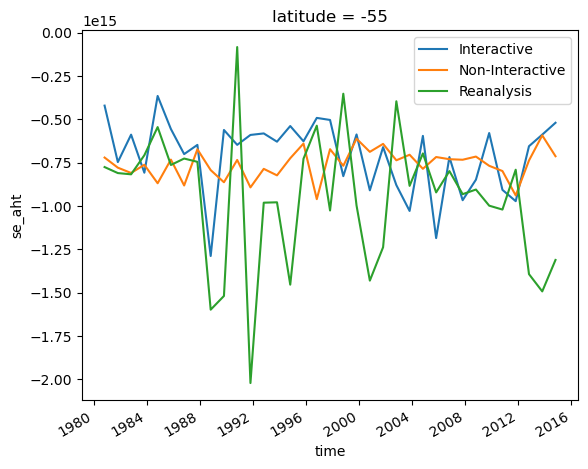

In [48]:
which_lat = -55

hist_interactive_time.sel(latitude=which_lat).plot.line(label='Interactive')
hist_non_interactive_time.sel(latitude=which_lat).plot.line(label='Non-Interactive')
reanalysis_time.sel(latitude=which_lat).plot.line(label='Reanalysis')

plt.legend(loc=0)
plt.show()